In [1]:
import numpy as np
try:
    from IPython.core.display import clear_output
    have_ipython = True
except ImportError:
    have_ipython = False
import sys
import datetime
%matplotlib inline
import matplotlib.pyplot as plt

def plotCurve(train_mean, train_std,test_mean,test_std,sizes):
    plt.plot(sizes, train_mean, 
            color='blue', marker='o', 
            markersize=5, 
            label='training accuracy')
    plt.fill_between(sizes, 
                  train_mean + train_std,
                   train_mean - train_std, alpha=0.15, color='blue')

    plt.plot(sizes, test_mean, 
              color='green', linestyle='--', 
              marker='s', markersize=5, 
             label='validation accuracy')
    plt.fill_between(sizes, 
                      test_mean + test_std,
                     test_mean - test_std, 
                    alpha=0.15, color='green')
    plt.xlabel('x_range')
    plt.ylabel('Accuracy')
    plt.show()
def likehoodScore(proba,y):
    return np.sum(proba * y)/proba.shape[0]

def firstNScore(n, pred, y):
    backup = np.array(pred, copy =True)
    for r in range(pred.shape[0]):
        row = backup[r]
        s = np.sort(row)
        for c in range(pred.shape[1]):
            temp = backup[r][c]
            backup[r][c] = False
            for j in range(1,n+1):
                if temp == s[-j]:
                    backup[r][c] = True
                    break
    res = np.sum(np.logical_and(backup,y))/pred.shape[0]
    return res               

def oneHotDecode(self, X_sample):
    result=None
    fiPos = 0
    colIndex = 0
    while colIndex < X_sample.shape[1]:
        if fiPos < len(self.ohe.n_values_) and colIndex == self.ohe.feature_indices_[fiPos]:                
            start = self.ohe.feature_indices_[fiPos]
            end_ = start+ self.ohe.n_values_[fiPos]
            #print("start{} end{}".format(start,end_))
            classes = np.argmax(X_sample[:,start:end_],axis=1).reshape(X_sample.shape[0],1)
            if result is None:
                result = classes
            else:
                result=np.hstack([result,classes])
            colIndex = end_
            fiPos = fiPos +1
        else:
            if result is None:
                result = X_sample[:,colIndex:colIndex+1]
            else:
                result=np.hstack([result, X_sample[:,colIndex:colIndex+1]])
            colIndex = colIndex +1
        
    return result 
def convertToDate(dayStamps):
    res = [] 
    for v in dayStamps:
        res.append(datetime.datetime.fromtimestamp(float(v)*24*60*60))
    return res


    

def precisionMatrix(proba, y):
    def _precisionClassify(df,proba, wins, c =0 ):
        for indx, v in enumerate(proba):
            row = 0
            col = 0
            if wins[indx] == c:
                col = 0
            else:
                col =1
            if v <0.2:
                row =6 
            elif v < 0.3 and  v >=0.2:
                row =5 
            elif v < 0.4 and v >= 0.3:
                row = 4 
            elif v < 0.5 and v >= 0.4:
                row = 3 
            elif v < 0.6 and v >= 0.5:
                row = 2 
            elif v < 0.8 and v >= 0.6:
                row = 1
            df.iloc[row,col] = df.iloc[row,col]+1 
        df[df.columns[2]] = df[df.columns[0]] /(df[df.columns[1]] + df[df.columns[0]])
        return df
    rowHeader = ['>80','60-80','50-60','40-50','30-40','20-30','<20']
    df = pd.DataFrame(np.zeros(shape=(7,3)),index=rowHeader, columns=['h_Correct', 'h_Wrong','h_Precent'])
    hproba = proba[:,0]
    wins = np.argmax(y,axis=1)
    df = _precisionClassify(df,hproba,wins)
    temp = pd.DataFrame(np.zeros(shape=(7,3)),index=rowHeader, columns=['d_Correct', 'd_Wrong','d_Precent'])
    dproba = proba[:,1]
    df = df.join(_precisionClassify(temp,dproba,wins,c=1))
    temp = pd.DataFrame(np.zeros(shape=(7,3)),index=rowHeader, columns=['a_Correct', 'a_Wrong','a_Precent'])
    aproba = proba[:,2]
    df = df.join(_precisionClassify(temp,aproba,wins,c=2))
    
    bound = pd.DataFrame(np.array([[0.8,1.0],[0.6,0.8],[0.5,0.6],[0.4,0.5],[0.3,0.4],[0.2,0.3],[0,0.2]] )
                                ,index=rowHeader, columns=['[lower', 'upper)'])
            
    return bound.join(df)
       
from datetime import date, timedelta
from sklearn.metrics import precision_score


def futureTest(mlp, X,y,numOfWeek = 10,verbose=False):
    decoded = oneHotDecode(c, X)
    dates = convertToDate(X[:,c.dateColumn])
    dates = [d - timedelta(days=2) for d in dates]    
    weeks  = [ v.isocalendar()[1] for v in dates]
    thisWeek = weeks[-1]
    start = -1
    last = X.shape[0]
    index = -1
    w = 0
    sum_proba =None 
    sum_y =None
    sum_train_proba=None
    sum_train_y=None
    while w < numOfWeek:
        if thisWeek != weeks[index]:
            start = X.shape[0] +index+1
            X_train = X[0:start, :]
            X_test = X[start:last,:]
            y_train = y[0:start,:]
            y_test = y[start:last,:]
            mlp.fit(X_train,y_train)
            decoded = oneHotDecode(c,X_test)
            home = np.array([c.inverseTeamMapping(decoded[:,0])]).reshape(X_test.shape[0],1)
            away = np.array([c.inverseTeamMapping(decoded[:,1])]).reshape(X_test.shape[0],1)
            stack = np.hstack([home,away])
            proba = mlp.predict_proba(X_test)
            train_proba =mlp.predict_proba(X_train)
            errorIndx = np.argmax(proba,axis=1) != np.argmax(y_test,axis=1)
            if sum_proba is None:
                sum_proba = proba
                sum_y = y_test
                sum_train_proba = train_proba
                sum_train_y = y_train
            else:
                sum_proba = np.vstack([sum_proba,proba])
                sum_y = np.vstack([sum_y,y_test])
                sum_train_proba = np.vstack([sum_train_proba, train_proba])
                sum_train_y= np.vstack([sum_train_y, y_train])
            if verbose == True:
                print("week{}".format(w))
                print("numOftest {} , score {}".format(X_test.shape[0],mlp.score(X_test,y_test)))
                print(np.hstack([stack[errorIndx],proba[errorIndx],y_test[errorIndx]]))
                print("first2 : {}",firstNScore(2,proba,y_test))
            last = start
            thisWeek = weeks[index]
            w = w+1
        index = index -1
        
    print("summary")
    print("score:")
    score = firstNScore(1,sum_proba,sum_y)
    print(score)
    print("2like")
    like2 = firstNScore(2,sum_proba,sum_y)
    print(precisionMatrix(sum_proba,sum_y))
    y_true= np.argmax(sum_y,axis=1)
    y_pred = np.argmax(sum_proba,axis=1)
    print("sum precision:{}".format(precision_score(y_true,y_pred,average=None)))
    return firstNScore(1,sum_train_proba,sum_train_y), score, like2


In [54]:
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
class FootballDataHelper:
    def __init__ (self, recentNum=5):
        self.win_mapping = {'H':0, 'D':1,'A':2}
        self.recentNum = recentNum
        self.df = None
        self.teamsData={}
        self.session = 0
        #self.hiddensCount = 2
       
    def addColumns(self,df, addition):    
        dates = df["Date"].drop_duplicates().values
        col_adds = []
        for colAdd in addition.columns:
             if colAdd not in df.columns:
                    df[colAdd]=np.zeros(shape=(df.shape[0],))
                    col_adds.append(colAdd)
        for date in dates:
            dateAddition= addition[addition['Date'] == date].sort(columns='HomeTeam')
            dateDf  = df [df['Date']==date].sort(columns='HomeTeam')
            for col in col_adds:
                dateDf[col] = dateAddition[col].values
            df.update(dateDf)
        return df
            
            
    def readFootBallData(self,year): 
        filename = "dataSet/E{}.csv".format(year)
        df = pd.read_csv(filename)
        #df = df.drop(df.columns[range(23,df.shape[1])], axis=1)
        #df = df.drop("Div",axis=1)
        df['Date'] = pd.to_datetime(df['Date'],dayfirst=True)
        df['session'] = pd.Series(np.ones(shape=(df.shape[0],))*self.session, index=df.index)
        self.session = self.session +1
        
        matchDetail = pd.read_csv("dataSet/match{}.csv".format(year))
        matchDetail['Date'] =pd.to_datetime(matchDetail['Date'])
        df = self.addColumns(df,matchDetail)
        
        
        
        if self.df is None:
            self.df = df
        else:
            self.df = pd.concat([self.df,df])
            
        self.df = self.df.reset_index(drop=True)
        teams = self.df['HomeTeam'].drop_duplicates()
        teamMap = {}
        for index , v in enumerate(teams):
            teamMap[v] = index
        self.teamsMap = teamMap
        referees = self.df['Referee'].drop_duplicates()
        refereesMap = {}
        for index , v in enumerate(referees):
            refereesMap[v] = index+1

        self.refereesMap = refereesMap
 
    def getTeam(self,dataFrame, teamName):       
        return dataFrame[(dataFrame["HomeTeam"] == teamName) | (dataFrame["AwayTeam"] == teamName)]
 
        
    def previousRecords(self,team, date , recentNum):
        prev = team[( team["Date"] < date)]
        
        if prev.shape[0] < recentNum :
            #print("less than min Num")
            return None
        else:
            return prev.iloc[-recentNum:]
    def readPredict (self, filename):
        df = pd.read_csv(filename)
        df['Date'] = pd.to_datetime(df['Date'],dayfirst=True)

        return df
    
    
  
    def inverseTeamMapping (self, col):
        inverseMap ={}
        for name in self.teamsMap.keys():        
            inverseMap[self.teamsMap[name]] = name
        res =[]
        for idex, v in enumerate(col):
            res.append(inverseMap[v])
        return res


    def readTeamMatch(self, teamName):
        df = pd.read_csv('teams/'+teamName+'.csv')
        df['1'] = pd.to_datetime(df['1'],yearfirst=True)
        #df['1']= (pd.to_numeric(df['1'])/1e9/24/60/60)
        self.teamsData[teamName]=df.sort(['1'],ascending=[False])
        self.teamsById[self.teamsMap[teamName]]=self.teamsData[teamName]
    
    def commonMapping(self, X):
        X['HomeTeam'] = X['HomeTeam'].map(self.teamsMap)
        X['AwayTeam'] = X['AwayTeam'].map(self.teamsMap)
        X['Referee']=X['Referee'].map(self.refereesMap).fillna(0)
        X['HTR'] = X['HTR'].map(self.win_mapping)
        X['FTR'] = X['FTR'].map(self.win_mapping)
        return X
    def initData(self, X, target,encode):
        X  = X.sort_values(by="Date")
        isInput = False
        if target is None:
            target =X      
        else:
            if self.ohe is None:
                raise Exception("Not yet get train data")
            isInput = True
            if encode == True:
                target = self.commonMapping(target)
        y=None
        if encode == True:    
            X =self.commonMapping(X)
            y = []
            for v in target['FTR']:
                y.append(range(3)==v)
        else:
            y = target['FTR'].values
        target_date = (pd.to_numeric(target['Date'])/1e9/24/60/60).values
        return isInput, X,y, target, target_date
   
    def aggregate(self,recents,nonExpand,isInput,encode):
        res =None
        if encode == True:
            if isInput==False:
                self.ohe = OneHotEncoder(categorical_features='all')
                self.ohe.fit(recents)
            res = self.ohe.transform(recents).toarray()
        else:
            res = np.array(recents)
        self.dateColumn = res.shape[1]
        res = np.hstack([res,nonExpand])
        return res
  
    def getH7(self,removeInsufficient=False, target=None,encode = True):
        #Simple recent win,draw, lose 
        df = self.df
        if removeInsufficient == True:
            df= df[df['Sufficient'] == 1]
        
        
        isInput, X, y,target, target_date = self.initData(df,target,encode)
        resy=[]
        resx=[]
        print("start format")
        recents = X[['HomeTeam','AwayTeam','Referee']].values
        haccp = X['HAccP'].values.reshape(X.shape[0],1)
        aaccp = X['AAccP'].values.reshape(X.shape[0],1)
        homeRecent = np.hstack([X[['HWin','HDraw','HLose']].values,
                                (X['HScore'].values - X['HConcede'].values).reshape(X.shape[0],1)])
        awayRecent = np.hstack([X[['AWin','ADraw','ALose']].values,
                                (X['AScore'].values - X['AConcede'].values).reshape(X.shape[0],1)])
        homeMoral = X['HMoral'].values.reshape(X.shape[0],1)
        awayMoral = X['AMoral'].values.reshape(X.shape[0],1)
        target_date = target_date.reshape(X.shape[0],1)
        nonExpand =np.hstack([target_date,X[['HRestDay','ARestDay','HS_Acc','AS_Acc','HST_Acc','AST_Acc']].values,haccp-aaccp,(haccp+1)/(aaccp+1),
                                homeRecent,awayRecent, homeMoral - awayMoral + haccp - aaccp])
        res = self.aggregate(recents,nonExpand,isInput,encode)
        print("finish")
        sys.stdout.flush()
        return res, np.array(y)
    def _getRank(self,x, X,teamName,recentNum):
        team = self.getTeam(X,teamName)
        prev = team[team['Date'] < x['Date']].values      
        for i in range(recentNum):
            pass
    def initRanking(self, n = 20):
        defaultPt = 1
        df = self.df.sort(columns=["Date"],ascending=[False])
        df["HPoints"] = pd.Series(np.zeros(shape=(df.shape[0],)))
        df["APoints"] = pd.Series(np.zeros(shape=(df.shape[0],)))
        df["HAccP"] = pd.Series(np.zeros(shape=(df.shape[0],)))
        df["AAccP"] = pd.Series(np.zeros(shape=(df.shape[0],)))
        hpoints= df["HPoints"].values
        apoints=df["APoints"].values
        ftr = df["FTR"].values
        for i in range(df.shape[0]):
            sys.stdout.write("\r progress {}".format(i))
            sys.stdout.flush()
            if ftr[i] == 'H':
                hpoints[i] = 3
                apoints[i] = 0
            elif ftr[i] == 'D':
                hpoints[i] = 1
                apoints[i] = 1
            else :
                hpoints[i] = 0
                apoints[i] = 3
        df["HPoints"]=hpoints
        df["APoints"]=apoints
        for teamName in self.teamsMap.keys():
            team  = df[(df['HomeTeam']==teamName) | (df['AwayTeam'] == teamName)] 
            hometeam = team['HomeTeam'].values
            hpoints = team['HPoints'].values
            apoints = team['APoints'].values
            psum = 0
            haccp = team['HAccP'].values
            aaccp = team['AAccP'].values
        
            for  i in range(0,n):
                if i < hpoints.shape[0]:
                    psum = psum + (hpoints[i] if hometeam[i] == teamName else apoints[i] ) 
                else:
                    psum = psum + defaultPt        
                    
        
            for j in range(team.shape[0]):

                if j+n < hpoints.shape[0]:                     
                    psum = psum + (hpoints[j+n] if hometeam[j+n]==teamName else apoints[j+n])
                else:
                    psum = psum + defaultPt 
                
                psum = psum - (hpoints[j] if hometeam[j]==teamName else apoints[j])
                    
                if hometeam[j] == teamName:
                    haccp[j]=psum
                else:
                    aaccp[j]=psum
            team['HAccp']=haccp
            team['AAccP']=aaccp
            #print(team[['HomeTeam','AwayTeam','HAccP','AAccP']])
            df.update(team)
            
            #print(df[['HomeTeam','AwayTeam','HAccP','AAccP']])
        self.df =df
        return df
    def initRecentData(self, n =5):
        df = self.df.sort(columns=["Date"],ascending=[False])
        df["HWin"] = pd.Series(np.zeros(shape=(df.shape[0],)))
        df["AWin"] = pd.Series(np.zeros(shape=(df.shape[0],)))
        df["HDraw"] = pd.Series(np.zeros(shape=(df.shape[0],)))
        df["ADraw"] = pd.Series(np.zeros(shape=(df.shape[0],)))
        df["HLose"] = pd.Series(np.zeros(shape=(df.shape[0],)))
        df["ALose"] = pd.Series(np.zeros(shape=(df.shape[0],)))
                
        df["HScore"] = pd.Series(np.zeros(shape=(df.shape[0],)))
        df["AScore"] = pd.Series(np.zeros(shape=(df.shape[0],)))
        df["HConcede"] = pd.Series(np.zeros(shape=(df.shape[0],)))
        df["AConcede"] = pd.Series(np.zeros(shape=(df.shape[0],)))
        df["HMoral"] = pd.Series(np.zeros(shape=(df.shape[0],)))
        df["AMoral"] = pd.Series(np.zeros(shape=(df.shape[0],)))
        df["HRestDay"]= pd.Series(np.zeros(shape=(df.shape[0],)))
        df["ARestDay"]= pd.Series(np.zeros(shape=(df.shape[0],)))
        #general
        generalList = ['HS','AS','HST','AST','H_Poss','A_Poss','H_tkPass_OK','A_atkPass_OK',
                       'H_atkPass_tot','A_atkPass_tot','H_ins','A_ins']
        generalOutput = []
        for attr in generalList:
            temp = attr+'_Acc'
            df[temp]=pd.Series(np.zeros(shape=(df.shape[0],)))
            generalOutput.append(temp)
        #
        df["Sufficient"] = pd.Series(np.ones(shape=(df.shape[0],)))
        
      
            
        
        hscore = df['FTHG'].values
        ascore = df['FTAG'].values
        hconcede = df ['FTAG'].values
        aconcede = df['FTHG'].values
               
        hwin = df['HWin'].values
        awin = df['AWin'].values
        hlose = df['HLose'].values
        alose = df['ALose'].values
        hdraw = df['HDraw'].values
        adraw = df['ADraw'].values
        hmoral = df['HMoral'].values
        amoral = df['AMoral'].values
        
        rankRatio = (df['HAccP'].values+1) / (df['AAccP'].values +1)
        
        
        ftr = df["FTR"].values
        for i in range(df.shape[0]):
            sys.stdout.write("\r progress {}".format(i))
            sys.stdout.flush()
            if ftr[i] == 'H':
                hwin[i] = 1
                hmoral[i] = 3 * 1/rankRatio[i]
                alose[i]= 1
                amoral[i] = -3 * 1/rankRatio[i]
            elif ftr[i] == 'D':
                hdraw[i] = 1
                hmoral[i] = 1 * 1/rankRatio[i]
                adraw[i] = 1
                amoral[i] = 1 * rankRatio[i]
            else :
                hlose[i] = 1
                hmoral[i] = -3*rankRatio[i]
                awin [i] = 1
                amoral[i] = 3*rankRatio[i]
        
        
        df["HWin"]=hwin
        df["AWin"]=awin
        df["HDraw"]=hdraw
        df["ADraw"]=adraw
        df["HLose"]=hlose
        df["ALose"]=alose
        df["HScore"]=hscore
        df["AScore"]=ascore
        df["HConcede"]=hconcede
        df["AConcede"]=aconcede
        df["HMoral"] = hmoral
        df["AMoral"] = amoral
        
        
        
        for teamName in self.teamsMap.keys():
            print(teamName)
            team  = df[(df['HomeTeam']==teamName) | (df['AwayTeam'] == teamName)] 
            hometeam = team['HomeTeam'].values
            hwin = team["HWin"].values
            awin = team["AWin"].values
            hlose= team["HLose"].values
            alose = team["ALose"].values
            hdraw = team["HDraw"].values
            adraw = team["ADraw"].values
            hscore = team["HScore"].values
            ascore = team["AScore"].values
            hconcede = team["HConcede"].values
            aconcede = team["AConcede"].values
            hmoral = team["HMoral"].values
            amoral = team["AMoral"].values
            hrestday = team["HRestDay"].values
            arestday = team["ARestDay"].values
            
            #general
            hs= team["HS"].values
            as_ = team["AS"].values
            hst = team["HST"].values
            ast = team["AST"].values
            original_list =[]
            output_list=[]
            for indx, o_attr in enumerate(generalList):
                original_list.append(team[o_attr].values)
                output_list.append(team[generalOutput[indx]].values)
            
            
            matchDate =team['Date'].values
            sufficient = team['Sufficient'].values
            teamMatchesDate = self.teamsData[teamName].sort('1',ascending=False)['1'].values
            
            restday = 0
            winsum =0 
            losesum=0
            drawsum=0
            scoresum =0
            concedesum=0
            moralsum = 0
            #print(team[['HomeTeam','AwayTeam','HWin']])
            teamAttrSum_list=[0 for i in range(int(len(original_list)/2))]
            for  i in range(0,n):
                if i < team.shape[0]:
                    scoresum = scoresum + (hscore[i] if hometeam[i] == teamName else ascore[i])
                    winsum = winsum + (hwin[i] if hometeam[i] == teamName else awin[i])
                    losesum= losesum + (hlose[i] if hometeam[i] == teamName else alose[i])
                    drawsum= drawsum + (hdraw[i] if hometeam[i] == teamName else adraw[i])
                    concedesum = concedesum+ (hconcede[i] if hometeam[i] == teamName else aconcede[i])
                    moralsum= moralsum+ (hmoral[i] if hometeam[i] == teamName else amoral[i])
                    for attrIndx in range(len(teamAttrSum_list)):
                        teamAttrSum_list[attrIndx] +=(original_list[2*attrIndx][i] if hometeam[i] == teamName else original_list[2*attrIndx+1][i])
                else:
                    # + 0
                    pass
            dateIndx = 0
            for j in range(team.shape[0]):
                while True:
                    if dateIndx >= teamMatchesDate.shape[0]:
                        sufficient[j] = False
                        break
                    if teamMatchesDate[dateIndx] < matchDate[j] :
                        restday = (matchDate[j] - teamMatchesDate[dateIndx])/np.timedelta64(1,'D')
                        break
                    else:
                        dateIndx = dateIndx + 1
                
                if j+n < team.shape[0]:                     
                    scoresum = scoresum + (hscore[j+n] if hometeam[j+n] == teamName else ascore[j+n])
                    winsum = winsum + (hwin[j+n] if hometeam[j+n] == teamName else awin[j+n])
                    losesum= losesum + (hlose[j+n] if hometeam[j+n] == teamName else alose[j+n])
                    drawsum= drawsum + (hdraw[j+n] if hometeam[j+n] == teamName else adraw[j+n])
                    concedesum = concedesum+ (hconcede[j+n] if hometeam[j+n] == teamName else aconcede[j+n])
                    moralsum= moralsum+ (hmoral[j+n] if hometeam[j+n] == teamName else amoral[j+n])
                    for attrIndx in range(len(teamAttrSum_list)):
                        teamAttrSum_list[attrIndx] += (original_list[2*attrIndx][j+n] if hometeam[j+n] == teamName else original_list[2*attrIndx+1][j+n])
                else:
                    sufficient[j] = False
                    
                
                scoresum = scoresum - (hscore[j] if hometeam[j] == teamName else ascore[j])
                winsum = winsum - (hwin[j] if hometeam[j] == teamName else awin[j])
                losesum= losesum - (hlose[j] if hometeam[j] == teamName else alose[j])
                drawsum= drawsum - (hdraw[j] if hometeam[j] == teamName else adraw[j])
                concedesum = concedesum - (hconcede[j] if hometeam[j] == teamName else aconcede[j])
                moralsum= moralsum - (hmoral[j] if hometeam[j] == teamName else amoral[j])
                for attrIndx in range(len(teamAttrSum_list)):
                    teamAttrSum_list[attrIndx] -=  (original_list[2*attrIndx][j] if hometeam[j] == teamName else original_list[2*attrIndx+1][j])
                    
                if hometeam[j] == teamName:
                    hscore[j] = scoresum
                    hwin[j] = winsum
                    hlose[j] = losesum
                    hdraw[j] = drawsum
                    hconcede[j] = concedesum
                    hmoral[j] = moralsum
                    hrestday[j] = restday
                    for attrIndx in range(len(teamAttrSum_list)):
                        output_list[2*attrIndx][j] = teamAttrSum_list[attrIndx]
                else:
                    ascore[j] = scoresum
                    awin[j] = winsum
                    alose[j] = losesum
                    adraw[j] = drawsum
                    aconcede[j] = concedesum
                    amoral[j] = moralsum
                    arestday[j] = restday
                    for attrIndx in range(len(teamAttrSum_list)):
                        output_list[2*attrIndx+1][j] = teamAttrSum_list[attrIndx]
            team["HWin"]=hwin
            team["AWin"]=awin
            team["HDraw"]=hdraw
            team["ADraw"]=adraw
            team["HLose"]=hlose
            team["ALose"]=alose
            team["HScore"]=hscore
            team["AScore"]=ascore
            team["HConcede"]=hconcede
            team["AConcede"]=aconcede
            team["HMoral"] = hmoral
            team["AMoral"] = amoral
            team['Sufficient'] = sufficient
            for indx in range(len(output_list)):
                team[generalList[indx]]= output_list[indx]
        
            #print(team[['HomeTeam','AwayTeam','HWin']])
            df.update(team)
            #print(df[['HomeTeam','AwayTeam','HAccP','AAccP']])
        self.df =df
        return df
    def initTeamData(self):
        self.teamsData={}
        self.teamsById={}
        for name in self.teamsMap.keys():
            self.readTeamMatch(name)
            

In [55]:
c = FootballDataHelper()
#c.readFootBallData("E0_1112.csv")
c.readFootBallData(2012)
c.readFootBallData(2013)
c.readFootBallData(2014)
c.readFootBallData(2015)
c.initTeamData()

/home/y/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:23: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/home/y/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/home/y/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:98: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [56]:
#c.df

In [57]:
df = c.initRanking()

 progress 1442

/home/y/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:177: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/home/y/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:228: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/y/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [58]:
df=c.initRecentData(n=5)

 progress 1442Leicester


/home/y/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:237: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


KeyError: 'A_atkPass_OK'

In [60]:
c.df['A_atkPass_Ok']

1442     49
1441    111
1440     72
1439     68
1436    100
1434     98
1435    126
1433     58
1437     78
1438     72
1432     83
1431    107
1430     67
1429    202
1428     84
1427     97
1426    143
1422     51
1418     93
1419    131
1420     51
1421     77
1423     93
1424     74
1425     85
1417     98
1416     65
1415     50
1414    101
1413     66
       ... 
36      112
28      123
27       77
26       85
25       64
24       98
23      104
22       72
21       51
20       69
18       86
19      117
17       58
16       82
15       78
14       47
13       40
12       44
11      143
10       55
9       172
8        44
7        83
2        72
4        61
3        43
1        70
5       128
6        62
0        35
Name: A_atkPass_Ok, dtype: float64

In [27]:
X,y = c.getH7(removeInsufficient = True)


start format
finish


In [ ]:
%matplotlib qt
def plotErrorDate(X_test, X_err, dateCol = 10):
    X_test_date =np.sort(X_test[:,c.dateColumn])
    X_date=[]
    y_date=[]
    for v in X_test_date:
        date = datetime.datetime.fromtimestamp(v*24*60*60)
        if len(X_date) ==0  or X_date[-1] != date:
            X_date.append(date)
            y_date.append(1)
        else:
            y_date[-1] = y_date[-1] +1
    plt.plot_date(X_date,y_date,xdate=True)
    X_err_d = np.sort(X_err[:,c.dateColumn])
    X_err_date=[]
    y_err_date = []
    for v in X_err_d:
        date = datetime.datetime.fromtimestamp(v*24*60*60)
        if len(X_err_date) ==0  or X_err_date[-1] != date:
            X_err_date.append(date)
            y_err_date.append(1)
        else:
            y_err_date[-1] = y_err_date[-1] +1
    plt.plot_date(X_err_date,y_err_date,xdate=True,color='red')
    plt.show()



In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.learning_curve import learning_curve
from custom import SoftMaxMLPClassifier
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
g_hiddenNodes = int(45)
g_alpha = 0 
clf = SoftMaxMLPClassifier(hidden_layer_sizes=[g_hiddenNodes], activation='logistic', algorithm='l-bfgs', alpha=g_alpha, 
              learning_rate_init=0.01,learning_rate='adaptive' ,max_iter=1000,early_stopping = False,verbose = 3)
mlp = Pipeline([ ('scl', StandardScaler()),('clf', clf)])

In [ ]:
mlp.fit(X,y)

In [ ]:
print ("start learning")
sys.stdout.flush()
train_sizes, train_scores, test_scores = learning_curve(estimator=mlp, 
                       X=X, 
                      y=y, 
                      train_sizes=np.linspace(0.1, 1.0, 4), 
                      cv=4,
                     n_jobs=1,verbose=3)
print("finishing")   
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)


print(test_mean)

In [ ]:
learningRes = np.vstack([train_sizes,train_mean,train_std,test_mean,test_std]).T


In [ ]:
learningDf = pd.DataFrame(learningRes,columns=['size','train_mean','train_std','test_mean','test_std'])
print(learningDf)

In [ ]:
%matplotlib inline
plotCurve(train_mean,train_std,test_mean,test_std,train_sizes)


In [ ]:
from sklearn.cross_validation import StratifiedKFold
def crossValidate(mlp, X,y, fold = 10):
    y_label = np.argmax(y,axis=1)

    kfold = StratifiedKFold(y=y_label, 
                             n_folds=fold,
                            random_state=1)

    scores = []
    train_scores=[]
    firstNScores = []
    for k, (train, test) in enumerate(kfold):

        mlp.fit(X[train], y[train])
        score = mlp.score(X[test], y[test])
        firstNScores.append(firstNScore(2, mlp.predict_proba(X[test]), y[test]))
        train_scores.append(mlp.score(X[train],y[train]))
        scores.append(score)
        print('Fold: %s, Class dist.: %s, Acc: %.3f' % (k+1, 
                    np.bincount(y_label[train]), score))    
        
        
    return train_scores,scores, firstNScores



In [ ]:

def lamda_test(mlp, X, y, lamdas):
    
    train_scores=[]
    test_scores=[]
    for lamda in lamdas:
        clf.set_params(alpha= lamda)
        train_s, test_s, firstNScores = crossValidate(mlp,X,y,fold=8)
      #  train_s, test_s, firstNScores =futureTest(mlp,X,y,numOfWeek=20) 
        train_scores.append(train_s)
        test_scores.append(test_s)
        print("lamda: {}, train: {}, test: {}".format(lamda, 
                    np.mean(train_s), np.mean(test_s)) )
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    plotCurve(train_mean,train_std,test_mean,test_std,lamdas)
    return np.array(train_scores),np.array(test_scores)

l_range = []
for i in range(0,50):
    l_range.append(2*i)
train_scores,test_scores = lamda_test(mlp,X,y,np.array(l_range))
#50

In [ ]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
alphaRes = np.vstack([l_range,train_mean,train_std,test_mean,test_std]).T
alphaDf = pd.DataFrame(alphaRes,columns=['alpha','train_mean','train_std','test_mean','test_std'])
print(alphaDf)

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.learning_curve import learning_curve
from custom import SoftMaxMLPClassifier
from sklearn.pipeline import Pipeline
%matplotlib inline
import matplotlib.pyplot as plt
def testNodeSize(start ,end):
    node_range = range(start,end,5)
    train_means = []
    train_std = []
    test_means =[]
    test_std=[]
    for node in node_range:   
        print("start node:{}".format(node))
        clf = SoftMaxMLPClassifier(hidden_layer_sizes=[node], activation='logistic', algorithm='l-bfgs', alpha=0, 
                  learning_rate_init=0.01,learning_rate='adaptive' ,max_iter=500,early_stopping = True,verbose = 3)
        mlp = Pipeline([('scl', StandardScaler()),('clf', clf)])
        train_scores,test_scores,first2 = crossValidate(mlp,X,y,fold=8)
      #  train_scores,test_scores , first2= futureTest(mlp, X,y,numOfWeek = 10)
        train_means.append(np.mean(train_scores))
        train_std.append(np.std(train_scores))
        test_means.append(np.mean(test_scores))
        test_std.append(np.std(test_scores))
        print("Node {}: train_mean {}  v.s. test_mean {}".format(node,np.mean(train_scores),np.mean(test_scores)))
    plotCurve(np.array(train_means),np.array(train_std),np.array(test_means),np.array(test_std),np.array(node_range))
    return node_range, train_means,train_std,test_means,test_std

In [ ]:
node_range, train_means,train_std,test_means,test_std=testNodeSize(1,X.shape[1] )

In [ ]:
nodeRes = np.vstack([node_range,train_means,train_std,test_means,test_std]).T
nodeDf = pd.DataFrame(nodeRes,columns=['nodeNum','train_mean','train_std','test_mean','test_std'])
print(nodeDf)

In [ ]:
clf.set_params(alpha=g_alpha)
print(clf)
train_score, test_score, first2 = futureTest(mlp,X,y,numOfWeek = 30, verbose=True)      


In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.learning_curve import learning_curve
from custom import SoftMaxMLPClassifier
from sklearn.pipeline import Pipeline
%matplotlib inline
import matplotlib.pyplot as plt
def testRecentNum(start, end):
    recent_range = range(start,end)
    train_means = []
    train_std = []
    test_means =[]
    test_std=[]
    first2_mean=[]
    for recent in recent_range:
        print("start recent:{}".format(recent))
        X,y = c.getH7(recent)
        clf = SoftMaxMLPClassifier(hidden_layer_sizes=[g_alpha], activation='logistic', algorithm='l-bfgs', alpha=g_alpha, 
                  learning_rate_init=0.01,learning_rate='adaptive' ,max_iter=500,early_stopping = True,verbose = 3)
        mlp = Pipeline([('scl', StandardScaler()),('clf', clf)])
        train_scores,test_scores, first2 = crossValidate(mlp,X,y,fold=10)
        #train_scores,test_scores, first2 = futureTest(mlp, X,y,numOfWeek = 15)
        train_means.append(np.mean(train_scores))
        train_std.append(np.std(train_scores))
        test_means.append(np.mean(test_scores))
        test_std.append(np.std(test_scores))
        first2_mean.append(np.mean(first2))
        print("recent {}: train_mean {}  v.s. test_mean {} , first2_mean {}".format(
                recent,np.mean(train_scores),np.mean(test_scores),np.mean(first2)))
    plotCurve(np.array(train_means),np.array(train_std),np.array(test_means),np.array(test_std),np.array(recent_range))
    return train_means,train_std,test_means,test_std,first2_mean



In [ ]:
train_means,train_std,test_means,test_std,first2_mean=testRecentNum(1 ,15)

In [ ]:

proba = mlp.predict_proba(X_test)
precisionMatrix(proba,y_test)



In [ ]:
#future
mlp.fit(X,y)
inData = c.readPredict("future.csv")
print(inData)
X_in, y_in = c.getH6(5,target=inData)
res = mlp.predict(X_in)
proba= mlp.predict_proba(X_in)
print(mlp.score(X_in,y_in))
print (np.hstack([proba,y_in]))


In [ ]:
return
print(X.shape)

In [28]:
X,y = c.getH7(removeInsufficient=True, encode=False)


start format
finish


In [29]:
print(X.shape)
df = pd.DataFrame(np.hstack([X,y.reshape(y.shape[0],1)]))

df.columns = ['home','away','Referee','time','HRestTime','ARestTime','HS_Acc','AS_Acc','HST_Acc','AST_Acc'
              ,'HAccP - AAccP','H/A','HWin','HDraw','HLose','H goal Diff',
'AWin','ADraw','ALose','A goal diff','moraldiff + h-a',
              'y']
print(df)

(1358, 21)
                home         away        Referee   time HRestTime ARestTime  \
0             Fulham     Man City       M Halsey  15612         7         3   
1            Norwich    Liverpool        M Jones  15612         2         2   
2            Everton  Southampton      L Probert  15612         3         3   
3              Stoke      Swansea         J Moss  15612         7         3   
4            Arsenal      Chelsea     M Atkinson  15612         2         3   
5         Man United    Tottenham          C Foy  15612         2         2   
6        Aston Villa    West Brom       A Taylor  15613         4         3   
7                QPR     West Ham  M Clattenburg  15614         4         5   
8              Wigan      Everton       K Friend  15619         7         7   
9          West Brom          QPR        M Jones  15619         6         4   
10          Man City   Sunderland      L Probert  15619         2         7   
11           Chelsea      Norwich       A

In [30]:

df.to_csv('dataSet/V8.csv',index=False)

In [6]:
X,y = c.getH7(removeInsufficient = True)

start format
finish


In [7]:
from sklearn.preprocessing import StandardScaler
X_scaled = StandardScaler().fit_transform(X)

In [8]:
from sklearn.cross_validation import train_test_split
def splitData(X,y):
    X_train, X_test1, y_train, y_test1 = train_test_split(X, y, test_size=0.3, random_state=42)
    X_test, X_val, y_test,y_val = train_test_split(X_test1, y_test1, test_size=0.5, random_state=42)
    return X_train, y_train, X_val, y_val, X_test, y_test

In [9]:
from keras.models import Sequential


Using Theano backend.
/home/y/anaconda3/lib/python3.5/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


In [10]:
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.optimizers import SGD, Adadelta, Adagrad
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping
def createModel(hidSize, inputDim):
    model = Sequential()
    model.add(Dense(hidSize[0], input_dim=inputDim, init='glorot_normal'))
    model.add(Activation('sigmoid'))
    model.add(Dropout(0.5))

    model.add(Dense(hidSize[1], init='glorot_normal'))
    model.add(Activation('sigmoid'))
    model.add(Dropout(0.5))

    model.add(Dense(3, init='glorot_normal'))
    model.add(Activation('softmax'))
    sgd = SGD(lr=1, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='categorical_crossentropy', optimizer='adadelta')
    return model
earlyCallback = EarlyStopping(patience=20,verbose=1)

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
x_range = range(len(history.history['val_loss']))
plt.plot(x_range,history.history['val_loss'])
plt.show()

In [35]:
from sklearn.cross_validation import StratifiedKFold
def crossValidate2(node_sizes, X,y, fold = 10):
    y_label = np.argmax(y,axis=1)

    kfold = StratifiedKFold(y=y_label, 
                             n_folds=fold,
                            random_state=1)

    scores = []
    train_scores=[]
    proba_test = []
    proba_y=[]
    for k, (train, test) in enumerate(kfold):
        earlyCallback = EarlyStopping(patience=20,verbose=1)
        model = createModel(node_sizes,X.shape[1])
        history = model.fit(X[train],y[train],verbose=0,nb_epoch=500, validation_split=0.1,show_accuracy=True, callbacks=[earlyCallback])
      #  firstNScores.append(firstNScore(2, model.predict_proba(X[test]), y[test]))
        score = model.evaluate(X[test],y[test])
        proba_test.append(model.predict_proba(X[test]))
        proba_y.append(y[test])
        train_scores.append(model.evaluate(X[train],y[train]))
        scores.append(score)
        print('Fold: %s, Class dist.: %s, val_loss: %.3f' % (k+1, 
                    np.bincount(y_label[train]), score))    
        
        
    return train_scores,scores, proba_test,proba_y




In [36]:
def testNodeNum(X,y, sizes):
    train_loss=[] 
    score_loss=[]
    for s in sizes:
        train_scores,scores,  proba_test,proba_y= crossValidate2([s,s],X,y,fold=5)
        print("size:{} , val_loss_mean:{}".format(s,np.mean(scores)))
        train_loss.append(train_scores)
        score_loss.append(scores)
    return train_loss,score_loss

In [37]:
sizes= range(5,X.shape[1],5)
train_loss,score_loss= testNodeNum(X_scaled,y,sizes)

Epoch 00129: early stopping
1085/1085 [==============================] - 0s     
Fold: 1, Class dist.: [479 265 341], val_loss: 1.005
Epoch 00170: early stopping
1085/1085 [==============================] - 0s     
Fold: 2, Class dist.: [479 265 341], val_loss: 0.997
Epoch 00238: early stopping
1087/1087 [==============================] - 0s     
Fold: 3, Class dist.: [479 266 342], val_loss: 0.993
Epoch 00118: early stopping
1087/1087 [==============================] - 0s     
Fold: 4, Class dist.: [479 266 342], val_loss: 1.024
Epoch 00028: early stopping
1088/1088 [==============================] - 0s     
Fold: 5, Class dist.: [480 266 342], val_loss: 1.061
size:5 , val_loss_mean:1.0156987103630872
Epoch 00090: early stopping
1085/1085 [==============================] - 0s     
Fold: 1, Class dist.: [479 265 341], val_loss: 0.996
Epoch 00161: early stopping
1085/1085 [==============================] - 0s     
Fold: 2, Class dist.: [479 265 341], val_loss: 0.995
Epoch 00103: early s

range(5, 96, 5)


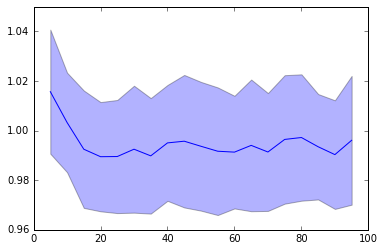

max: 20


In [38]:
print(sizes)
loss = (np.mean(score_loss,axis=1))
loss_std = (np.std(score_loss,axis=1))
plt.plot(sizes,loss)
plt.fill_between(sizes,loss-loss_std,loss+loss_std,alpha=0.3)
plt.show()
print("max: {}".format(sizes[np.argmin(loss,axis=0)]))

In [22]:

def futureTest2(node_sizes, X,y,ori_dates, numOfWeek = 10,verbose=False):
    decoded = oneHotDecode(c, X)
    dates = convertToDate(ori_dates)
    dates = [d - timedelta(days=2) for d in dates]    
    weeks  = [ v.isocalendar()[1] for v in dates]
    thisWeek = weeks[-1]
    start = -1
    last = X.shape[0]
    index = -1
    w = 0
    sum_proba =None 
    sum_y =None
    sum_train_proba=None
    sum_train_y=None
    model = createModel(node_sizes,X.shape[1])
    results = None
    while w < numOfWeek:
        if thisWeek != weeks[index]:
            print("week{}".format(w))
            start = X.shape[0] +index+1
            X_train = X[0:start, :]
            X_test = X[start:last,:]
            y_train = y[0:start,:]
            y_test = y[start:last,:]
            earlyCallback = EarlyStopping(patience=20,verbose=1)
            history = model.fit(X_train,y_train,verbose=0,nb_epoch=500, validation_split=0.1, callbacks=[earlyCallback])
            decoded = oneHotDecode(c,X_test)
            home = np.array([c.inverseTeamMapping(decoded[:,0])]).reshape(X_test.shape[0],1)
            away = np.array([c.inverseTeamMapping(decoded[:,1])]).reshape(X_test.shape[0],1)
            stack = np.hstack([home,away])
            proba = model.predict_proba(X_test)
            train_proba =model.predict_proba(X_train)
            errorIndx = np.argmax(proba,axis=1) != np.argmax(y_test,axis=1)
            tresult = np.hstack([np.array([w for i in range(proba.shape[0])]).reshape(proba.shape[0],1),
                                 ori_dates[start:last].reshape(proba.shape[0],1),stack,proba,y_test])
            if sum_proba is None:
                sum_proba = proba
                sum_y = y_test
                sum_train_proba = train_proba
                sum_train_y = y_train
                results =    tresult
            else:
                sum_proba = np.vstack([sum_proba,proba])
                sum_y = np.vstack([sum_y,y_test])
                sum_train_proba = np.vstack([sum_train_proba, train_proba])
                sum_train_y= np.vstack([sum_train_y, y_train])
                results =  np.vstack([results, tresult])
            if verbose == True:
                print("numOftest {} , loss {}".format(X_test.shape[0],model.evaluate(X_test,y_test)))               
                print (tresult)
                print("first2 : {}",firstNScore(2,proba,y_test))
            last = start
            thisWeek = weeks[index]
            w = w+1
        index = index -1
    start = X.shape[0] +index+1
    print("start compute precision_mat")
    print(X[0:start,:].shape)
    print(y[0:start,:].shape)
    _,_, proba_test,proba_y = crossValidate2([85,85],X[0:start,:],y[0:start,:],fold=10)
    p_matrix = precisionMatrix(np.vstack(proba_test),np.vstack(proba_y))
    print("summary")
    print("score:")
    score = firstNScore(1,sum_proba,sum_y)
    print(score)
    print("2like")
    like2 = firstNScore(2,sum_proba,sum_y)
    print(precisionMatrix(sum_proba,sum_y))
    y_true= np.argmax(sum_y,axis=1)
    y_pred = np.argmax(sum_proba,axis=1)
    print("sum precision:{}".format(precision_score(y_true,y_pred,average=None)))
    resultdf= pd.DataFrame(results, columns=['week','DayStamp','HomeTeam','AwayTeam','H_prob','D_prob','A_prob','H','D','A'])
    return sum_proba, sum_y,resultdf,p_matrix

In [23]:
sum_proba, sum_y,resultdf,p_matrix= futureTest2([85,85],X_scaled,y,X[:,c.dateColumn],numOfWeek=25,verbose=False)

week0
Epoch 00090: early stopping
1348/1348 [==============================] - 0s     
week1
Epoch 00021: early stopping
1343/1343 [==============================] - 0s     
week2
Epoch 00022: early stopping
1328/1328 [==============================] - 0s     
week3
Epoch 00028: early stopping
1315/1315 [==============================] - 0s     
week4
Epoch 00021: early stopping
1305/1305 [==============================] - 0s     
week5
Epoch 00026: early stopping
1293/1293 [==============================] - 0s     
week6
Epoch 00024: early stopping
1285/1285 [==============================] - 0s     
week7
Epoch 00030: early stopping
1275/1275 [==============================] - 0s     
week8
Epoch 00022: early stopping
1258/1258 [==============================] - 0s     
week9
Epoch 00023: early stopping
1255/1255 [==============================] - 0s     
week10
Epoch 00022: early stopping
1244/1244 [==============================] - 0s     
week11
Epoch 00025: early stopping
1225/12

In [24]:
p_matrix

,[lower,upper),h_Correct,h_Wrong,h_Precent,d_Correct,d_Wrong,d_Precent,a_Correct,a_Wrong,a_Precent
>80,0.8,1.0,21,10,0.677419,0,0,NaN,0,0,NaN
60-80,0.6,0.8,191,77,0.712687,0,0,NaN,14,8,0.636364
50-60,0.5,0.6,71,75,0.486301,0,0,NaN,74,49,0.601626
40-50,0.4,0.5,75,97,0.436047,0,0,NaN,81,92,0.468208
30-40,0.3,0.4,67,116,0.366120,42,97,0.302158,60,131,0.314136
20-30,0.2,0.3,45,136,0.248619,191,548,0.258457,63,170,0.270386
<20,0.0,0.2,19,96,0.165217,31,187,0.142202,51,303,0.144068


In [25]:
def findRecordsBy(self,df):
    #print((df['DayStamp']).values)
    #date = convertToDate((df['DayStamp']).values)
    #df["Date"] = date
    
    home = df['HomeTeam'].values
    away = df['AwayTeam'].values
    origin = self.df[["Date","HomeTeam","AwayTeam","JocH","JocD","JocA"]]
    origin["DayStamp"]=(pd.to_numeric(origin['Date'])/1e9/24/60/60).values
    origin["DayStamp"] = origin["DayStamp"].apply(lambda x: "%.f"%(float(x)))
    df['DayStamp']=df['DayStamp'].apply(lambda x: "%.f"%(float(x)))
    return origin.merge(df,left_on=['DayStamp',"HomeTeam","AwayTeam"],right_on=["DayStamp","HomeTeam","AwayTeam"],how='inner')
   
  

In [26]:
withodds = findRecordsBy(c,resultdf)

/home/y/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/y/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [27]:
import math
def formatMatrixs(oddDf , precisionDf):
    proba_mat = oddDf[['H_prob','D_prob','A_prob']].values
    print(precisionDf)
    def locatePrecision(proba_mat, precisionDf):
        precisionMat = precisionDf.values
        pre_cols=[4,7,10]
        def convert(proba, pre_col = 4):
            if proba < 0.2:
                return proba
            for i in range(precisionMat.shape[0]):
                if precisionMat[i,0] <= proba and proba < precisionMat[i,1] :
                    if math.isnan(precisionMat[i,pre_col]):
                        return proba
                    else:
                        return precisionMat[i,pre_col]
        h_fproba = np.array([ convert(float(proba)) for proba in proba_mat[:,0] ] )
        d_fproba = np.array([ convert(float(proba),pre_col=7) for proba in proba_mat[:,1] ] )
        a_fproba = np.array([ convert(float(proba),pre_col=10) for proba in proba_mat[:,2] ] )
        return h_fproba, d_fproba,a_fproba
    h_fproba, d_fproba,a_fproba =locatePrecision(proba_mat,precisionDf)
    fproba_mat = np.hstack([h_fproba,d_fproba,a_fproba]).reshape(3,h_fproba.shape[0]).T
    print(fproba_mat)
    odd_mat = oddDf[['JocH','JocD','JocA']].values
    print(odd_mat)
    print(fproba_mat*odd_mat)
    win_mat = oddDf[['H','D','A']].values
    print(win_mat)
    return fproba_mat,odd_mat,win_mat

In [28]:
fproba_mat,odd_mat,win_mat= formatMatrixs(withodds,p_matrix)

       [lower  upper)  h_Correct  h_Wrong  h_Precent  d_Correct  d_Wrong  \
>80       0.8     1.0         21       10   0.677419          0        0   
60-80     0.6     0.8        191       77   0.712687          0        0   
50-60     0.5     0.6         71       75   0.486301          0        0   
40-50     0.4     0.5         75       97   0.436047          0        0   
30-40     0.3     0.4         67      116   0.366120         42       97   
20-30     0.2     0.3         45      136   0.248619        191      548   
<20       0.0     0.2         19       96   0.165217         31      187   

       d_Precent  a_Correct  a_Wrong  a_Precent  
>80          NaN          0        0        NaN  
60-80        NaN         14        8   0.636364  
50-60        NaN         74       49   0.601626  
40-50        NaN         81       92   0.468208  
30-40   0.302158         60      131   0.314136  
20-30   0.258457         63      170   0.270386  
<20     0.142202         51      303   0.

In [29]:
def strategy1(fproba_mat,odd_mat,win_mat):
    exp = odd_mat * fproba_mat
    print(exp)
    maxi = np.argmax(exp,axis=1)
    print(maxi)
    y_true = np.argmax(win_mat,axis=1)
    spent = 0
    expectation = 0
    income = 0
    for i in range(maxi.shape[0]):
        if exp[i,maxi[i]] > 1:
            expectation = expectation+ exp[i,maxi[i]]
            spent = spent+1
            if maxi[i] == y_true[i]:
                income = income + odd_mat[i,maxi[i]]
            
            
        
    print("Spent:{}, Income:{}, expectation:{}".format(spent,income,expectation))

In [30]:
strategy1(fproba_mat,odd_mat,win_mat)

[[  1.03339552e+00   1.04675237e+00   8.94297838e-01]
 [  8.21849315e-01   9.04600812e-01   6.44336531e-01]
 [  8.96994536e-01   9.36690647e-01   8.16753927e-01]
 [  1.00178082e+00   8.27063599e-01   8.51716738e-01]
 [  6.71511628e-01   1.08776978e+00   1.44656652e+00]
 [  6.96132597e-01   8.14140731e-01   1.36569106e+00]
 [  1.71044776e+00   6.39047328e-01   6.70557940e-01]
 [  7.53767123e-01   9.56292287e-01   8.99754539e-01]
 [  7.98142077e-01   9.06474820e-01   9.73821990e-01]
 [  8.80813953e-01   7.88294993e-01   9.32832618e-01]
 [  9.55161290e-01   3.13147581e-01   4.83380637e-01]
 [  1.91640922e-01   5.21662380e-01   1.16852630e+00]
 [  1.21575342e+00   7.62449256e-01   5.33796820e-01]
 [  1.36740331e+00   1.23884892e+00   6.78901734e-01]
 [  8.65616438e-01   8.27063599e-01   1.12210300e+00]
 [  9.94475138e-01   9.51798561e-01   8.56820809e-01]
 [  8.57734807e-01   8.27063599e-01   9.13005780e-01]
 [  1.37505661e-01   1.86258842e-01   2.04885686e+00]
 [  7.98208955e-01   7.75562

In [31]:
def strategy3(fproba_mat,odd_mat,win_mat,info, z = 0.5  ):
    exp = odd_mat * fproba_mat
    y_true = np.argmax(win_mat,axis=1)
    spent = 0
    expectation = 0
    income = 0
    total = fproba_mat.shape[0]
    withdraw = 0
    buy = 0
    homeTeam = info["HomeTeam"].values
    awayTeam = info["AwayTeam"].values
    receipt = []
    def chooseFrom(match, chosable):
        max_prob = -1
        c = 0
        for choice in chosable:
            if fproba_mat[match,choice] > max_prob:
                c = choice
                max_prob = fproba_mat[match,choice]
        return c
    for match in range(exp.shape[0]):
        chosable = []
        for choose in range(3):
            if exp[match,choose]> 1 and fproba_mat[match,choose] >= z:
                chosable.append(choose)
                
        if len(chosable) == 0:
            withdraw= withdraw+1
            continue
        choice = chooseFrom(match,chosable)
        expectation = expectation+ exp[match,choice]
        spent = spent+1
        buy =buy +1 
        receipt.append(np.hstack([homeTeam[match],awayTeam[match], odd_mat[match,choice],choice,y_true[match],fproba_mat[match,:]]))
        if choice == y_true[match]:
            income = income + odd_mat[match,choice]
    print(buy)
    print("Spent:{}, Income:{}, expectation:{}, withdraw:{}(total:{})".
          format(spent,income,expectation,withdraw,total))
    receiptDf = pd.DataFrame(receipt,columns=["home","away","odd of choice","choice","result","Hp","Dp","Ap"])
    return spent,income,expectation,withdraw,total,receiptDf

In [32]:
spent,income,expectation,withdraw,total,receipt = strategy3(fproba_mat,odd_mat,win_mat,withodds,z=0.55)

90
Spent:90, Income:91.14999999999998, expectation:139.70355912289673, withdraw:171(total:261)


In [ ]:
receipt


In [ ]:
z_range = range(30,80,2)
spents = []
incomes = []
exps = []
withs = []
for z in z_range:
    fz = z/100
    print(z)
    spent,income,expectation,withdraw,total,_ = strategy3(fproba_mat,odd_mat,win_mat,withodds,z=fz) 
    spents.append(spent)
    incomes.append(income)
    exps.append(expectation)
    withs.append(withdraw)
    
    

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(z_range, spents)
plt.plot(z_range, incomes,color='green')
plt.plot(z_range, np.array(incomes)/np.array(spents)*100,color='red')
plt.plot(z_range,exps,color='black')
plt.show()

In [33]:
def strategy4(fproba_mat,odd_mat,win_mat,info, z = 0.2 ,e =1.8 ):
    exp = odd_mat * fproba_mat
    y_true = np.argmax(win_mat,axis=1)
    spent = 0
    expectation = 0
    income = 0
    total = fproba_mat.shape[0]
    withdraw = 0
    buy = 0
    homeTeam = info["HomeTeam"].values
    awayTeam = info["AwayTeam"].values
    receipt = []
    def chooseFrom(match, chosable):
        max_prob = -1
        c = 0
        for choice in chosable:
            if fproba_mat[match,choice] > max_prob:
                c = choice
                max_prob = fproba_mat[match,choice]
        return c
    for match in range(exp.shape[0]):
        chosable = []
        for choose in range(3):
            if exp[match,choose]> e and fproba_mat[match,choose] >= z:
                chosable.append(choose)
                
        if len(chosable) == 0:
            withdraw= withdraw+1
            continue
        choice = chooseFrom(match,chosable)
        expectation = expectation+ exp[match,choice]
        spent = spent+1
        buy =buy +1 
        receipt.append(np.hstack([homeTeam[match],awayTeam[match], odd_mat[match,choice],choice,y_true[match],fproba_mat[match,:]]))
        if choice == y_true[match]:
            income = income + odd_mat[match,choice]
    print(buy)
    print("Spent:{}, Income:{}, expectation:{}, withdraw:{}(total:{})".
          format(spent,income,expectation,withdraw,total))
    receiptDf = pd.DataFrame(receipt,columns=["home","away","odd of choice","choice","result","Hp","Dp","Ap"])
    return spent,income,expectation,withdraw,total,receiptDf

In [34]:
spent,income,expectation,withdraw,total,receipt = strategy4(fproba_mat,odd_mat,win_mat,withodds,z=0.2,e=1.5)

85
Spent:85, Income:110.48000000000002, expectation:171.54410507473867, withdraw:176(total:261)
